In [31]:
from typing_extensions import Literal
from pydantic import BaseModel
import random
import re

from langchain_core.messages import AIMessage, HumanMessage
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import Command

from langchain_google_vertexai import ChatVertexAI
from google.cloud.aiplatform_v1beta1.types import Tool as VertexTool

from IPython.display import display, Image, Markdown

members = ["habits", "summaries", "alerts"]
# options = members + ["FINISH"]

# Define the router schema with Pydantic BaseModel
class Router(BaseModel):
    """Worker to route to next. If no workers needed, route to FINISH."""
    # next: Literal[*options]
    next: Literal[*members]
    # next: str

# Define graph state
class State(MessagesState):
    next: str

# Define the nodes
def router(state: State) -> Command[Literal[*members]]:
    # print("outer loop: router")

    llm = ChatVertexAI(model="gemini-2.0-flash-lite-001", temperature=0)

    router_prompt = (
               """
               <instructions>
               \nYou are the critical routing component of a healthcare AI system.
               \nYour response will only be one of 3 options: 'FINISH', 'habits', 'summaries', or 'alerts'.
               \nBased on <user query>, decide if the user is...
               \n(1) requesting custom workout routines and diet plans -> respond 'habits'.
               \n(2) OR requesting a simplified summary of complex medical information -> respond 'summaries'.
               \n(3) OR need to be alerted because of health risks based on <patient data>  -> respond 'alerts'.
               \nRemember, only output 'habits', 'summaries', or 'alerts'.
               \n</instructions>
               """)


    messages = [
        {"role": "system", "content": router_prompt},] + state.get("messages", [])
    # print(messages)
    resp = llm.with_structured_output(schema=Router).invoke(messages)
    # print(resp)
    value = resp.next
    messages = state.get("messages", []) + [AIMessage(content=value)]
    
    goto = value
    # if value == "FINISH":
    #     goto = END

    # note how Command allows you to BOTH update the graph state AND route to the next node
    return Command(
        # this is the state update
        update={"messages": messages, "next": value},
        # this is a replacement for an edge
        goto=goto,
    )


def habits(state: State) -> Command[Literal["__end__"]]:
    # print("outer loop: habits")
    
    # llm = ChatVertexAI(model="gemini-2.0-flash")
    llm = ChatVertexAI(model="gemini-2.0-pro-exp-02-05", temperature=0)

    habits_prompt = (
               """
               <instructions>
               \nYou are a healthy habits expert. You are a critical component of a healthcare AI system.
               \nYou have been empowered by a healthcare provider to guide patients towards better health outcomes.
               \nGenerate customized workout routines and meal plans based on <patient data>.
               \nBe friendly and respectful.
               \nBe concise and structured.
               \n</instructions>
               """)

    messages = [
        {"role": "system", "content": habits_prompt},] + state.get("messages", [])

    # resp = llm.invoke(messages, tools=[VertexTool(google_search={})],)
    resp = llm.invoke(messages)
    # print(resp)
    messages = state.get("messages", []) + [AIMessage(content=resp.content)]

    return Command(
        # this is the state update
        update={"messages": messages, "next": "FINISH"},
        # this is a replacement for an edge
        goto=END,
    )

def summaries(state: State) -> Command[Literal["__end__"]]:
    # print("outer loop: summaries")
    
    # llm = ChatVertexAI(model="gemini-2.0-flash")
    llm = ChatVertexAI(model="gemini-2.0-pro-exp-02-05", temperature=0)

    summaries_prompt = (
               """
               <instructions>
               \nYou are an expert at simplifying complicated written medical content. You are a critical component of a healthcare AI system.
               \nYou have been empowered by a healthcare provider to guide patients towards better health outcomes.
               \nSummarize complex medical information (e.g., from doctor's notes, research papers) in <user query> into layman's terms.
               \nAnswer patient questions in <user query> about their conditions and treatments.
               \n<patient data> will also be provided, in case it is needed.
               \nBe friendly and respectful.
               \nBe concise and structured.
               \n</instructions>
               """)

    messages = [
        {"role": "system", "content": summaries_prompt},] + state.get("messages", [])

    # resp = llm.invoke(messages, tools=[VertexTool(google_search={})],)
    resp = llm.invoke(messages)
    # print(resp)
    messages = state.get("messages", []) + [AIMessage(content=resp.content)]

    return Command(
        # this is the state update
        update={"messages": messages, "next": "FINISH"},
        # this is a replacement for an edge
        goto=END,
    )

def alerts(state: State) -> Command[Literal["__end__"]]:
    # print("outer loop: alerts")
    
    # llm = ChatVertexAI(model="gemini-2.0-flash")
    llm = ChatVertexAI(model="gemini-2.0-pro-exp-02-05", temperature=0)

    alerts_prompt = (
               """
               <instructions>
               \nYou are a medical risk-assessment expert. You are a critical component of a healthcare AI system.
               \nYou have been empowered by a healthcare provider to guide patients towards better health outcomes.
               \nAnalyze <patient data> and proactively identify potential health risks or deviations from normal measurment levels.
               \nGenerate alerts and offer personalized recommendations for intervention.
               \nBe friendly and respectful.
               \nBe concise and structured.
               \n</instructions>
               """)

    messages = [
        {"role": "system", "content": alerts_prompt},] + state.get("messages", [])

    # resp = llm.invoke(messages, tools=[VertexTool(google_search={})],)
    resp = llm.invoke(messages)
    # print(resp)
    messages = state.get("messages", []) + [AIMessage(content=resp.content)]

    return Command(
        # this is the state update
        update={"messages": messages, "next": "FINISH"},
        # this is a replacement for an edge
        goto=END,
    )

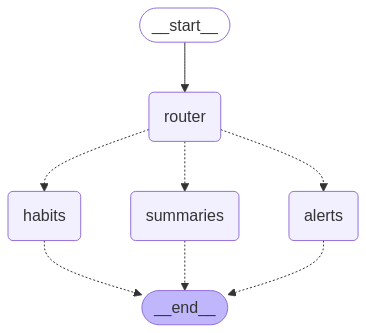

In [32]:
builder = StateGraph(State)
builder.add_edge(START, "router")
builder.add_node(router)
builder.add_node(habits)
builder.add_node(summaries)
builder.add_node(alerts)
# note: there are no edges between nodes A, B and C!

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [34]:
message = {"messages": HumanMessage(content="""
                                    
<user_query>review patient data and create alerts and remediation plans</user_query>
                                    
<patient_data>                                                                                                     
[{
  "patient_id": "9",
  "age": "59",
  "gender": "Male",
  "race": "Black or African American",
  "occupation": "Bus Driver",
  "medical_conditions": "Sleep Apnea",
  "visit_date": "2024-02-28",
  "visit_reason": "Sleep study follow-up",
  "blood_pressure": "130/80",
  "heart_rate": "76",
  "blood_glucose": null,
  "respiratory_rate": "16",
  "oxygen_saturation": null,
  "total_cholesterol": null,
  "ldl_cholesterol": null,
  "smoker": "Yes",
  "drinker": "Light",
  "exercise": "Sedentary"
}, {
  "patient_id": "9",
  "age": "59",
  "gender": "Male",
  "race": "Black or African American",
  "occupation": "Bus Driver",
  "medical_conditions": "Sleep Apnea",
  "visit_date": "2024-05-05",
  "visit_reason": "CPAP machine check",
  "blood_pressure": "128/78",
  "heart_rate": "74",
  "blood_glucose": null,
  "respiratory_rate": "16",
  "oxygen_saturation": null,
  "total_cholesterol": null,
  "ldl_cholesterol": null,
  "smoker": "Yes",
  "drinker": "Light",
  "exercise": "Sedentary"
}]
</patient_data>
                                    """),}

# Create a thread
config = {"configurable": {"thread_id": random.randint(0, 1000)}}

def extract_user_query(text):
    """Extracts the content within <user_query> tags."""
    match = re.search(r"<user_query>(.*?)</user_query>", text, re.DOTALL)
    if match:
        return match.group(1).strip()
    else:
        return None

display(Markdown(f"**Human:** {extract_user_query(message['messages'].content)}"))

def process_messages(messages):
    for message in messages:
        if isinstance(message, AIMessage):
            if message.content not in ('habits', 'summaries', 'alerts'):
                if isinstance(message.content, list):
                    all_parts = ' '.join(map(str, message.content))
                    display(Markdown(f"**AI:** {all_parts}"))
                else:
                    display(Markdown(f"**AI:** {message.content}"))

for chunk in graph.stream(message, config, stream_mode="updates"):
    for key, value in chunk.items():
        messages = value['messages']
        process_messages(messages)
            

**Human:** review patient data and create alerts and remediation plans

**AI:**  and recommendations for patient ID 9.

***

**Alerts:**

*   **Smoking:** The patient is a smoker, which significantly increases the risk of cardiovascular disease, respiratory problems, and various cancers.
*   **Sedentary Lifestyle:** The patient's sedentary lifestyle contributes to an increased risk of obesity, cardiovascular disease, and other health issues.
*    **Sleep Apnea:** Should be monitored and treated.

**Recommendations:**

*   **Smoking Cessation:**
    *   Strongly advise the patient to quit smoking.
    *   Offer resources such as counseling, nicotine replacement therapy, or other medications.
    *   Set a quit date and provide follow-up support.
*   **Increase Physical Activity:**
    *   Recommend at least 150 minutes of moderate-intensity or 75 minutes of vigorous-intensity aerobic activity per week.
    *   Suggest incorporating physical activity into the daily routine, such as walking during breaks or using stairs.
*   **Sleep Apnea:**
    *    Ensure the Patient is using and maintaining any prescribed treatments.

**Follow-up:**

*   Schedule regular follow-up appointments to monitor progress and provide ongoing support.
*   Reassess risk factors at each visit and adjust recommendations as needed.

***

**Disclaimer:** *This assessment is based on limited data and should not replace a comprehensive evaluation by a healthcare professional. The recommendations provided are for informational purposes only and do not constitute medical advice.*
